# Tarea 6
## Francisco Javier Peralta Ramírez

Para el problema IMDB, construya una red de dos canales, una Recurrente y otra Densa. La recurrente procesa datos previamente "incrustados" y la densa considera un vectopr de tamaño a lo mas 10,000 con estras binarias que indicas si la palabra con dicho índice es contenida en la reseña (red de dos entradas). La red tienen un sola salida que significa la interpretación del sentir (positivo o negativo). Usar API de Kreras

In [67]:
import numpy as np
import csv

import matplotlib.pyplot as plt

In [94]:
data_test   = []
target_test = [] #can be neg, pos
data_train   = []
target_train = [] #can be neg, pos 
with open('imdb_utf8.csv', encoding='utf-8') as csvfile:
    data_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(data_reader, None) #skip first row
    for row in data_reader:
        if(row[-2] == 'unsup'): continue
        if row[1] == 'test' :
            data_test.append(row[2])
            target_test.append(1 if row[-2] == 'pos' else 0) #mapeamos neg -> 0 , pos -> 1
        else :
            data_train.append(row[2])
            target_train.append(1 if row[-2] == 'pos' else 0) #mapeamos neg -> 0 , pos -> 1

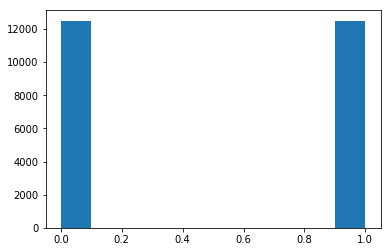

In [95]:
plt.hist(target_train)
plt.show()